# Human hematopoiesis analysis with the CytoTRACEKernel

In this analysis, we use the CytoTRACEKernel to recover human bone marrow development. To run the analysis, ensure that
the processed data is either already saved, or generate it using the corresponding notebook in the `pseudotime/`
directory.

The corresponding data can be generated through the preprocessing notebooks `pseudotime/preprocessing.ipynb`, or
downloaded driectly from [here](https://figshare.com/ndownloader/files/53394941) and should be
saved in `data/bone_marrow/processed/adata.h5ad`, _i.e._,

```bash
mkdir -p ../../data/bone_marrow/processed/
wget https://figshare.com/ndownloader/files/53394941 -O ../../data/bone_marrow/processed/adata.h5ad
```

## Library imports

In [1]:
from tqdm import tqdm

import pandas as pd

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import anndata as ad
import cellrank as cr
import scanpy as sc
import scvelo as scv

from crp import DATA_DIR, FIG_DIR

## General settings

In [2]:
cr.settings.verbosity = 4
sc.settings.verbosity = 2
scv.settings.verbosity = 3

In [3]:
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map="viridis")

## Constants

In [4]:
SAVE_FIGURES = False
if SAVE_FIGURES:
    (FIG_DIR / "cytotracekernel").mkdir(parents=True, exist_ok=True)

FIGURE_FORMAT = "svg"

In [5]:
SAVE_RESULTS = True
if SAVE_RESULTS:
    (DATA_DIR / "bone_marrow" / "results").mkdir(parents=True, exist_ok=True)

In [6]:
TERMINAL_STATES = ["Ery", "CLP", "cDC", "pDC", "Mono"]

In [7]:
STATE_TRANSITIONS = [
    ("HSC", "MEP"),
    ("MEP", "Ery"),
    ("HSC", "HMP"),
    ("HMP", "Mono"),
    ("HMP", "CLP"),
    ("HMP", "DCPre"),
    ("DCPre", "pDC"),
    ("DCPre", "cDC"),
]

## Function definitions

## Data loading

In [8]:
adata = ad.io.read_h5ad(DATA_DIR / "bone_marrow" / "processed" / "adata.h5ad")
adata

AnnData object with n_obs × n_vars = 6881 × 1500
    obs: 'leiden', 'celltype', 'n_counts', 'palantir_pseudotime'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'MAGIC_imputed_data'
    obsp: 'connectivities', 'distances'

## Data preprocessing

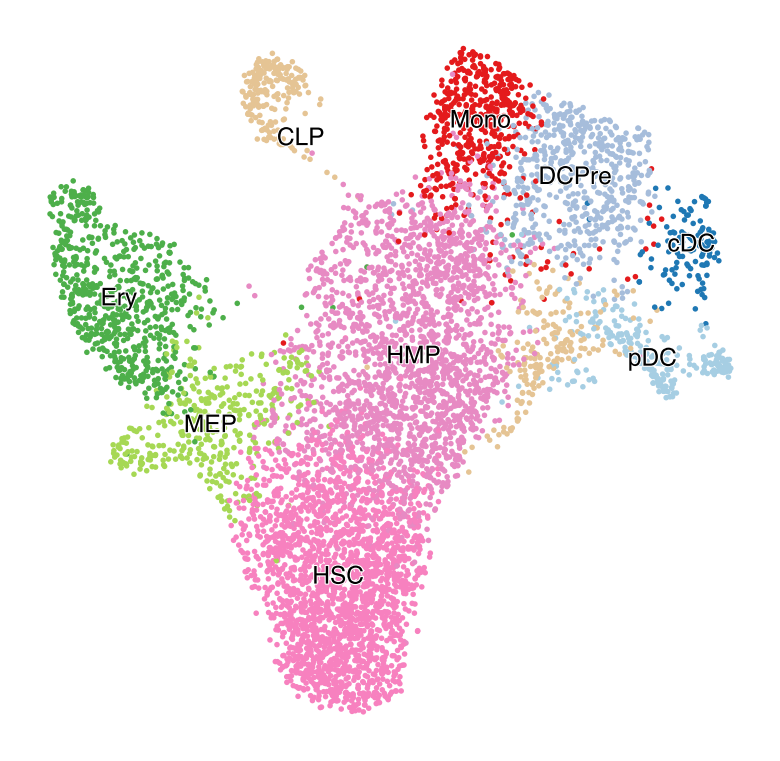

In [9]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 6))
    scv.pl.scatter(adata, basis="umap", color=["celltype"], size=25, dpi=100, title="", ax=ax)
    plt.show()

In [10]:
adata.layers["spliced"] = adata.X
adata.layers["unspliced"] = adata.X

scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## CytoTRACEKernel

### Kernel

In [11]:
ctk = cr.kernels.CytoTRACEKernel(adata)
ctk.compute_cytotrace()

Computing CytoTRACE score with `1500` genes. Consider using more than `10000` genes
DEBUG: Correlating all genes with number of genes expressed per cell
Adding `adata.obs['ct_score']`
       `adata.obs['ct_pseudotime']`
       `adata.obs['ct_num_exp_genes']`
       `adata.var['ct_gene_corr']`
       `adata.var['ct_correlates']`
       `adata.uns['ct_params']`
    Finish (0:00:00)


CytoTRACEKernel[n=6881]

/Users/philipp/miniforge3/envs/crp-py311/lib/python3.11/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


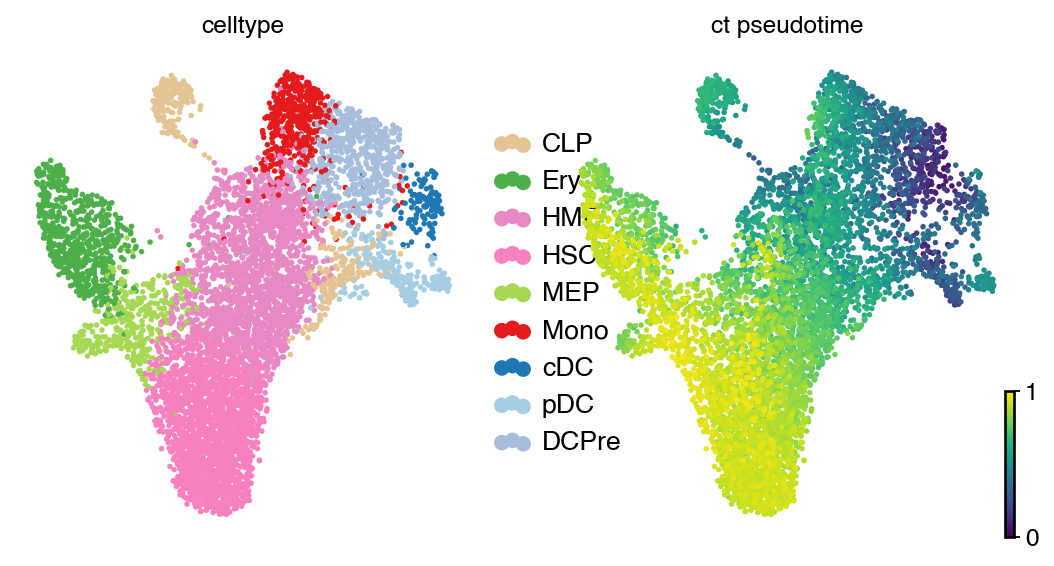

In [12]:
with mplscience.style_context():
    scv.pl.scatter(
        adata, basis="umap", color=["celltype", "ct_pseudotime"], legend_loc="right", color_map="viridis", size=25
    )
    plt.show()

In [13]:
ctk.compute_transition_matrix(threshold_scheme="soft", nu=0.5)

Computing transition matrix based on pseudotime


  0%|          | 0/6881 [00:00<?, ?cell/s]

    Finish (0:00:00)


CytoTRACEKernel[n=6881, dnorm=False, scheme='soft', b=10.0, nu=0.5]

### Estimator

Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:03)


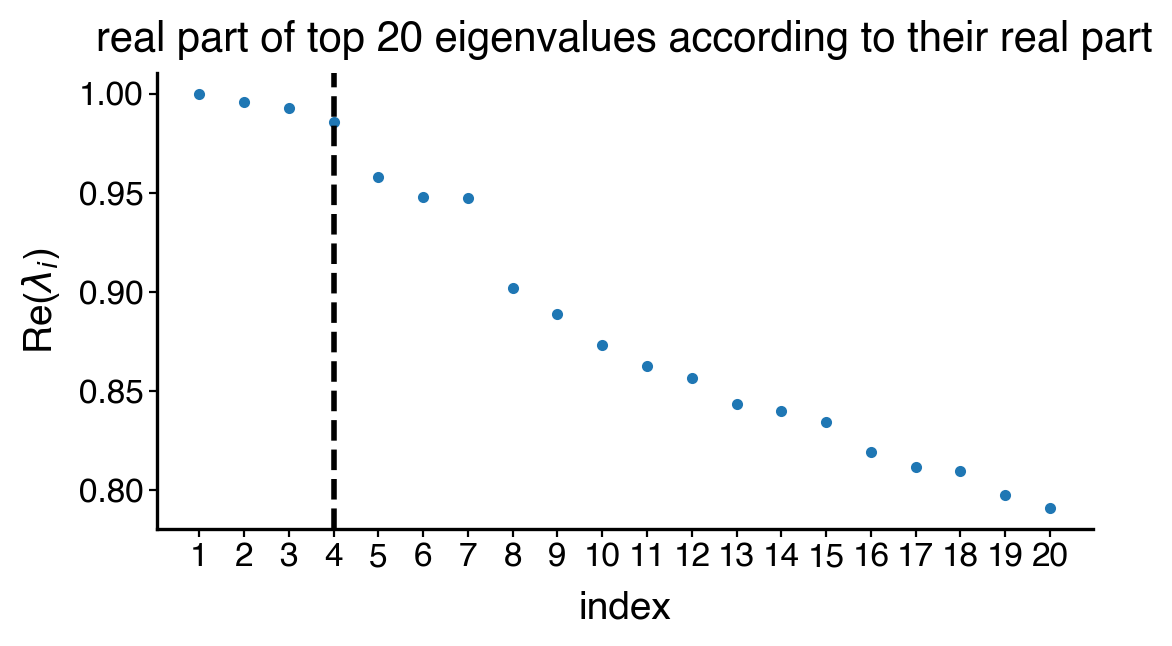

In [14]:
estimator = cr.estimators.GPCCA(ctk)
estimator.compute_schur(n_components=20)
with mplscience.style_context():
    if SAVE_FIGURES:
        save = FIG_DIR / "cytotracekernel" / f"spectrum.{FIGURE_FORMAT}"
    else:
        save = False
    estimator.plot_spectrum(real_only=True, figsize=(6, 3), save=save)
    plt.show()

Computing `4` macrostates
DEBUG: Setting the macrostates using macrostates memberships
DEBUG: Raising an exception if there are less than `6` cells.
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


/Users/philipp/miniforge3/envs/crp-py311/lib/python3.11/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/Users/philipp/miniforge3/envs/crp-py311/lib/python3.11/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/philipp/miniforge3/envs/crp-py311/lib/python3.11/site-packages/scvelo/plotting/utils.py:1396: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/Users/philipp/miniforge3/envs/crp-py311/lib/python3.11/site-packages/scvelo/plotting/utils.py:1397: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)


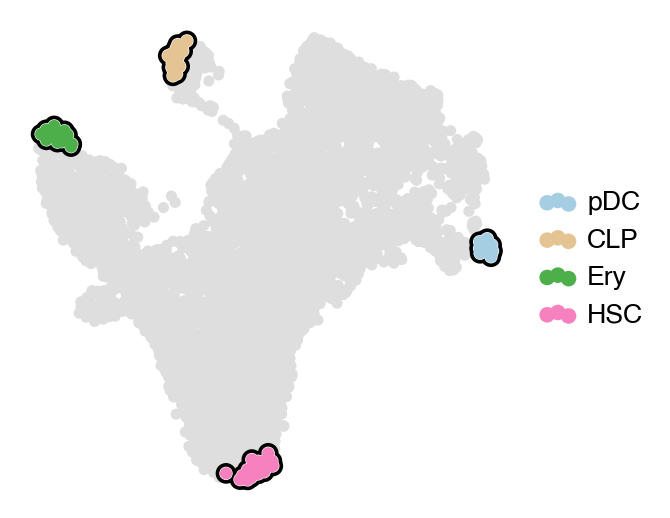

In [15]:
estimator.compute_macrostates(4, cluster_key="celltype")

with mplscience.style_context():
    estimator.plot_macrostates(which="all", basis="umap", legend_loc="right", title="", size=100)
    if SAVE_FIGURES:
        fig, ax = plt.subplots(figsize=(6, 6))
        estimator.plot_macrostates(which="all", basis="umap", legend_loc=False, title="", size=100, ax=ax)
        fig.savefig(
            FIG_DIR / "cytotracekernel" / "4_macrostates.png",
            dpi=400,
            transparent=True,
            bbox_inches="tight",
        )

    plt.show()

Computing `7` macrostates
DEBUG: Setting the macrostates using macrostates memberships
DEBUG: Raising an exception if there are less than `6` cells.
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:01)


/Users/philipp/miniforge3/envs/crp-py311/lib/python3.11/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/Users/philipp/miniforge3/envs/crp-py311/lib/python3.11/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/philipp/miniforge3/envs/crp-py311/lib/python3.11/site-packages/scvelo/plotting/utils.py:1396: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/Users/philipp/miniforge3/envs/crp-py311/lib/python3.11/site-packages/scvelo/plotting/utils.py:1397: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)


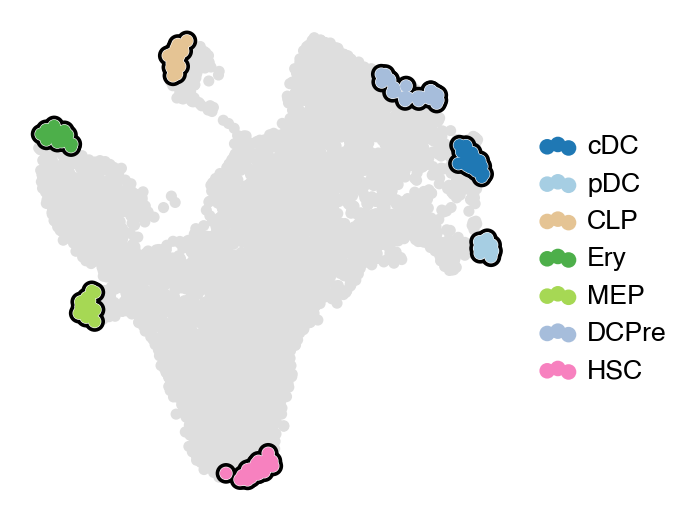

In [16]:
estimator.compute_macrostates(7, cluster_key="celltype")

with mplscience.style_context():
    estimator.plot_macrostates(which="all", basis="umap", legend_loc="right", title="", size=100)
    if SAVE_FIGURES:
        fig, ax = plt.subplots(figsize=(6, 6))
        estimator.plot_macrostates(which="all", basis="umap", legend_loc=False, title="", size=100, ax=ax)
        fig.savefig(
            FIG_DIR / "cytotracekernel" / "7_macrostates.png",
            dpi=400,
            transparent=True,
            bbox_inches="tight",
        )

    plt.show()

Computing `15` macrostates
DEBUG: Setting the macrostates using macrostates memberships
DEBUG: Raising an exception if there are less than `6` cells.
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:20)


/Users/philipp/miniforge3/envs/crp-py311/lib/python3.11/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/Users/philipp/miniforge3/envs/crp-py311/lib/python3.11/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/philipp/miniforge3/envs/crp-py311/lib/python3.11/site-packages/scvelo/plotting/utils.py:1396: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/Users/philipp/miniforge3/envs/crp-py311/lib/python3.11/site-packages/scvelo/plotting/utils.py:1397: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)


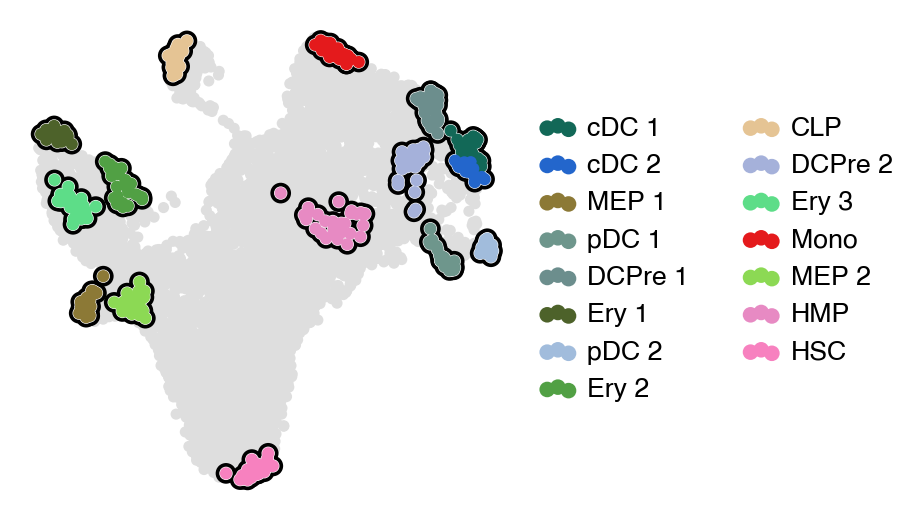

In [17]:
estimator.compute_macrostates(15, cluster_key="celltype")

with mplscience.style_context():
    estimator.plot_macrostates(which="all", basis="umap", legend_loc="right", title="", size=100)
    if SAVE_FIGURES:
        fig, ax = plt.subplots(figsize=(6, 6))
        estimator.plot_macrostates(which="all", basis="umap", legend_loc=False, title="", size=100, ax=ax)
        fig.savefig(
            FIG_DIR / "cytotracekernel" / "15_macrostates.png",
            dpi=400,
            transparent=True,
            bbox_inches="tight",
        )

    plt.show()

In [18]:
cluster_key = "celltype"

tsi_score = estimator.tsi(n_macrostates=15, terminal_states=TERMINAL_STATES, cluster_key=cluster_key)
print(f"TSI score: {tsi_score:.2f}")

if SAVE_RESULTS:
    estimator._tsi.to_df().to_parquet(DATA_DIR / "bone_marrow" / "results" / "ct_tsi.parquet")

Computing `15` macrostates
DEBUG: Setting the macrostates using macrostates memberships
DEBUG: Raising an exception if there are less than `6` cells.
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:18)
Computing `14` macrostates
DEBUG: Setting the macrostates using macrostates memberships
DEBUG: Raising an exception if there are less than `6` cells.
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:16)
Computing `13` macrostates
DEBUG: Setting the macrostates using macrostates memberships
DEBUG: Raising an exception if there are less than `6` cells.
Adding `.macrostates`
       `.macrostates_members

/Users/philipp/miniforge3/envs/crp-py311/lib/python3.11/site-packages/anndata/utils.py:307: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
/Users/philipp/miniforge3/envs/crp-py311/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


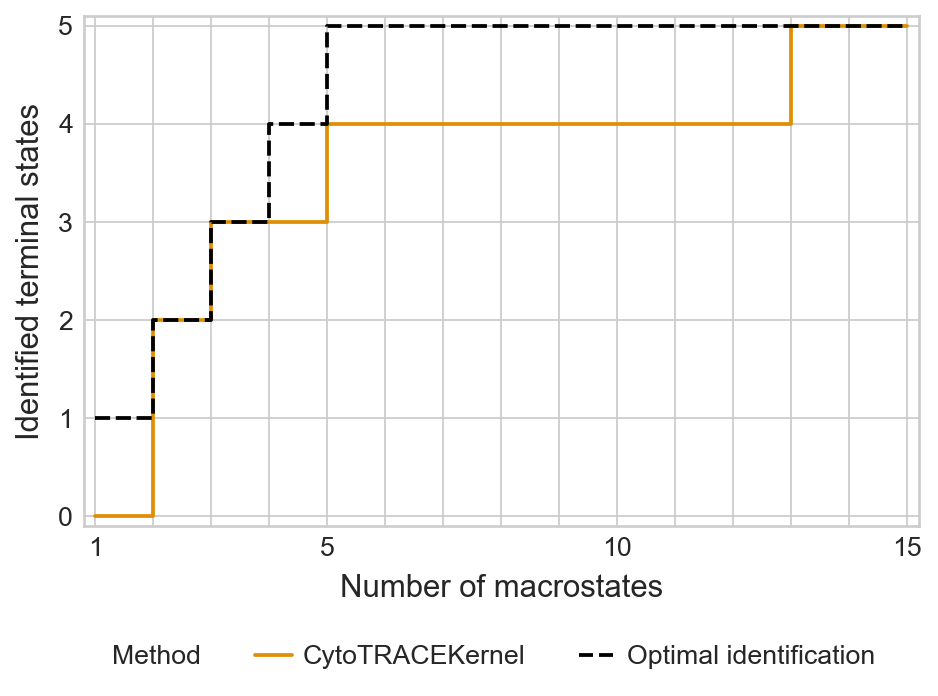

In [19]:
palette = {"CytoTRACEKernel": "#DE8F05", "Optimal identification": "#000000"}

if SAVE_FIGURES:
    save = FIG_DIR / "cytotracekernel" / f"tsi_ranking.{FIGURE_FORMAT}"
else:
    save = None

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    estimator.plot_tsi(palette=palette, save=save)
    plt.show()

DEBUG: Raising an exception if there are less than `6` cells.
Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


/Users/philipp/miniforge3/envs/crp-py311/lib/python3.11/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/Users/philipp/miniforge3/envs/crp-py311/lib/python3.11/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/philipp/miniforge3/envs/crp-py311/lib/python3.11/site-packages/scvelo/plotting/utils.py:1396: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/Users/philipp/miniforge3/envs/crp-py311/lib/python3.11/site-packages/scvelo/plotting/utils.py:1397: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)


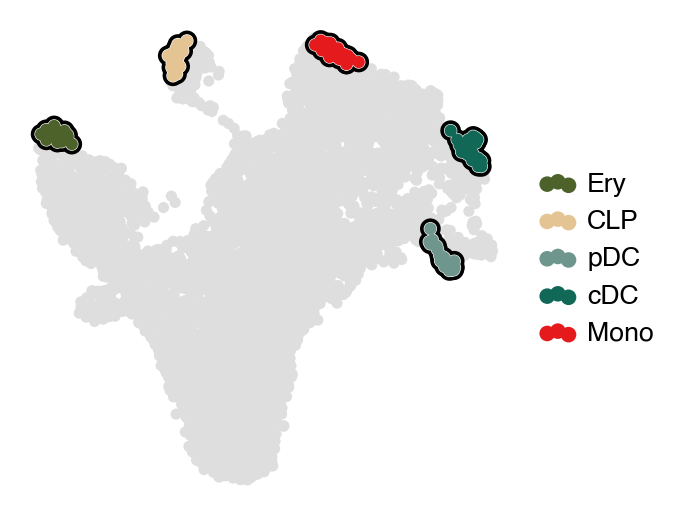

In [20]:
estimator.set_terminal_states(["Ery_1", "CLP", "pDC_1", "cDC_1", "Mono"])
estimator.rename_terminal_states({"Ery_1": "Ery", "pDC_1": "pDC", "cDC_1": "cDC"})

with mplscience.style_context():
    estimator.plot_macrostates(which="terminal", basis="umap", legend_loc="right", title="", size=100)

    if SAVE_FIGURES:
        fig, ax = plt.subplots(figsize=(6, 6))
        estimator.plot_macrostates(which="terminal", basis="umap", legend_loc=False, title="", size=100, ax=ax)
        fig.savefig(
            FIG_DIR / "cytotracekernel" / "terminal_states.png",
            dpi=400,
            transparent=True,
            bbox_inches="tight",
        )

    plt.show()

Computing fate probabilities
DEBUG: Solving the linear system using `PETSc` solver `'gmres'` on `1` core(s) with no preconditioner and `tol=1e-06`


  0%|          | 0/5 [00:00<?, ?/s]

Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:00)


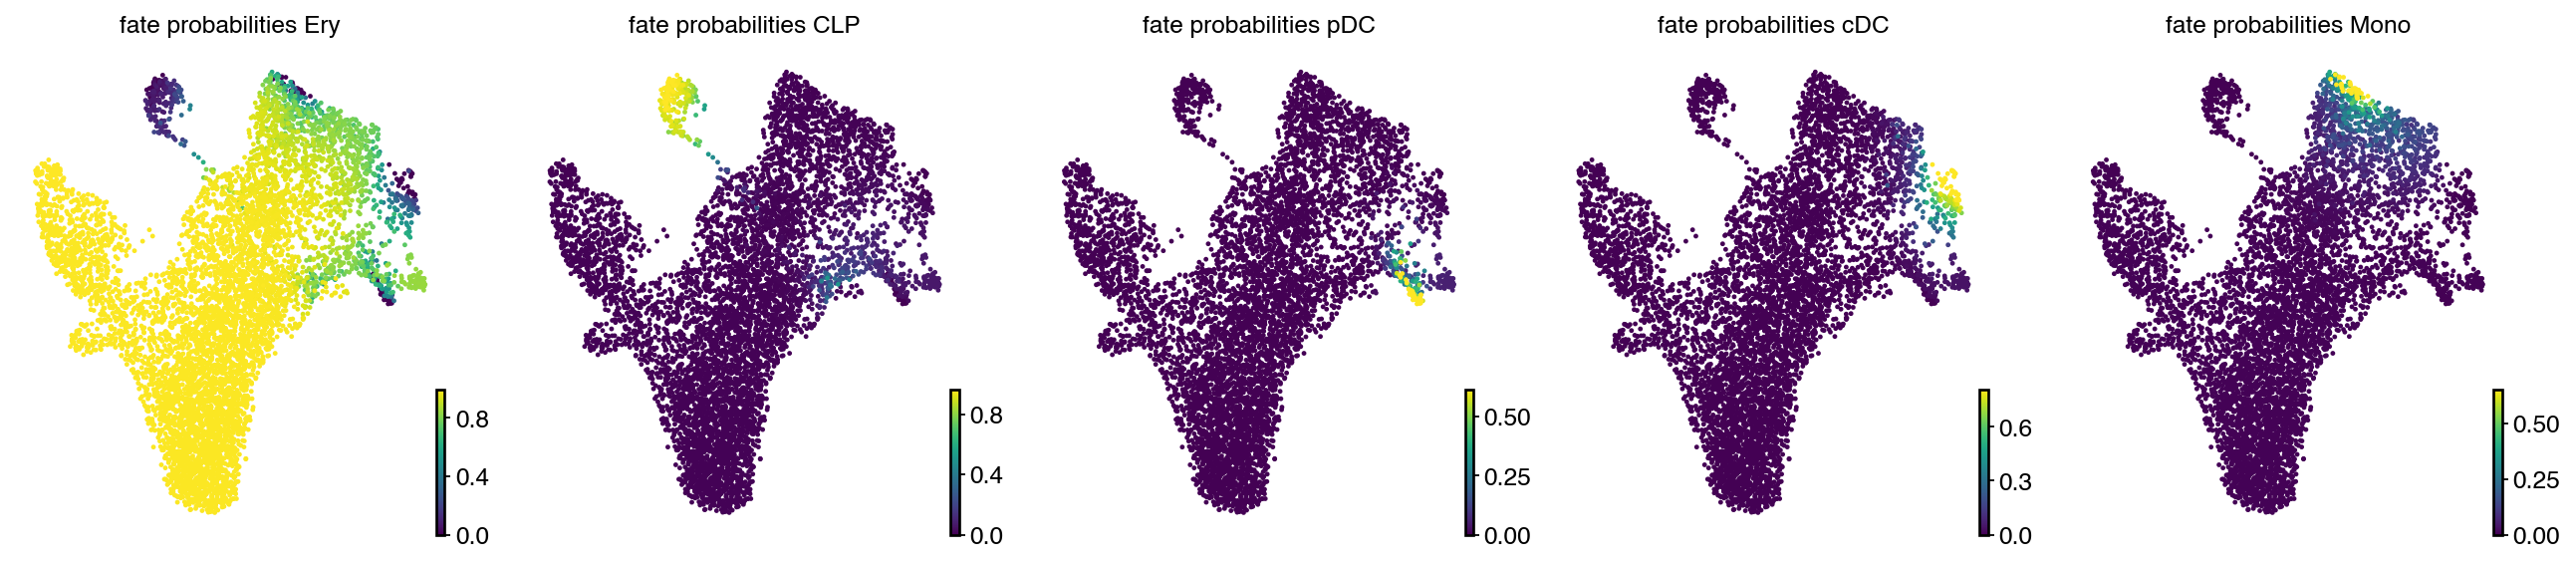

In [21]:
estimator.compute_fate_probabilities()
with mplscience.style_context():
    estimator.plot_fate_probabilities(same_plot=False, basis="umap", ncols=5)
    plt.show()

if SAVE_FIGURES:
    bdata = adata.copy()
    bdata.obs[estimator.fate_probabilities.names.tolist()] = estimator.fate_probabilities.X

    for lineage in estimator.fate_probabilities.names.tolist():
        with mplscience.style_context():
            fig, ax = plt.subplots(figsize=(6, 6))
            scv.pl.scatter(bdata, basis="umap", color=lineage, cmap="viridis", title="", colorbar=False, ax=ax)
            fig.savefig(
                FIG_DIR / "cytotracekernel" / f"{lineage.lower()}_fate_terminal_set.png",
                dpi=400,
                transparent=True,
                bbox_inches="tight",
            )
            plt.show()
    del bdata

In [22]:
cluster_key = "celltype"
rep = "X_pca"

cbc = []
for source, target in tqdm(STATE_TRANSITIONS):
    _cbc = ctk.cbc(source=source, target=target, cluster_key=cluster_key, rep=rep)

    cbc.append(
        pd.DataFrame(
            {
                "state_transition": [f"{source} - {target}"] * len(_cbc),
                "cbc": _cbc,
            }
        )
    )
cbc = pd.concat(cbc)

if SAVE_RESULTS:
    cbc.to_parquet(DATA_DIR / "bone_marrow" / "results" / "ct_cbc.parquet")

cbc.head()

100%|██████████| 8/8 [00:00<00:00, 13.36it/s]


,state_transition,cbc
0,HSC - MEP,0.799256
1,HSC - MEP,0.572809
2,HSC - MEP,0.702549
3,HSC - MEP,0.409971
4,HSC - MEP,0.866234
